In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import h5py
import torch
from tqdm.auto import tqdm

import warnings
warnings.filterwarnings('ignore')

import matplotlib
import matplotlib.pyplot as plt
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
np.set_printoptions(precision=2, suppress=False)

In [13]:
G_s, X_s, Y_s = [], [], []

pipeline = 9377999
with h5py.File(f'yearly/pipeline_{pipeline}/SourcedOnlyPBNN_1_saliency.h5', 'r') as h5f:
    for county in h5f.keys():
        print(county)
        try:
            G_s.append(h5f[f'{county}/G_S_sum'][()])
            X_s.append(h5f[f'{county}/X'] - np.mean(h5f[f'{county}/X']))
            Y_s.append(h5f[f'{county}/Y'] - np.mean(h5f[f'{county}/Y']))
        except:
            continue
            
        print(G_s[-1].shape, X_s[-1].shape, Y_s[-1].shape)

Arizona_Maricopa
(3, 3, 548, 685) (548, 685) (548, 685)
California_Los Angeles
(3, 3, 688, 401) (688, 401) (688, 401)
California_Orange
(3, 3, 207, 183) (207, 183) (207, 183)
California_Riverside
(3, 3, 367, 888) (367, 888) (367, 888)
California_San Diego
(3, 3, 375, 412) (375, 412) (375, 412)
California_Santa Clara
(3, 3, 227, 231) (227, 231) (227, 231)
Florida_Hillsborough
(3, 3, 225, 208) (225, 208) (225, 208)
Michigan_Oakland
(3, 3, 171, 166) (171, 166) (171, 166)
Michigan_Wayne
(3, 3, 151, 166) (151, 166) (151, 166)
Nevada_Clark
(3, 3, 674, 528) (674, 528) (674, 528)
New York_Nassau
(3, 3, 124, 100) (124, 100) (124, 100)
New York_Suffolk
(3, 3, 314, 387) (314, 387) (314, 387)
Pennsylvania_Allegheny
(3, 3, 167, 167) (167, 167) (167, 167)
Pennsylvania_Philadelphia
(3, 3, 100, 74) (100, 74) (100, 74)
Texas_Bexar
(3, 3, 216, 203) (216, 203) (216, 203)
Texas_Dallas
(3, 3, 150, 147) (150, 147) (150, 147)


221.74999999999932 171.75000000000014


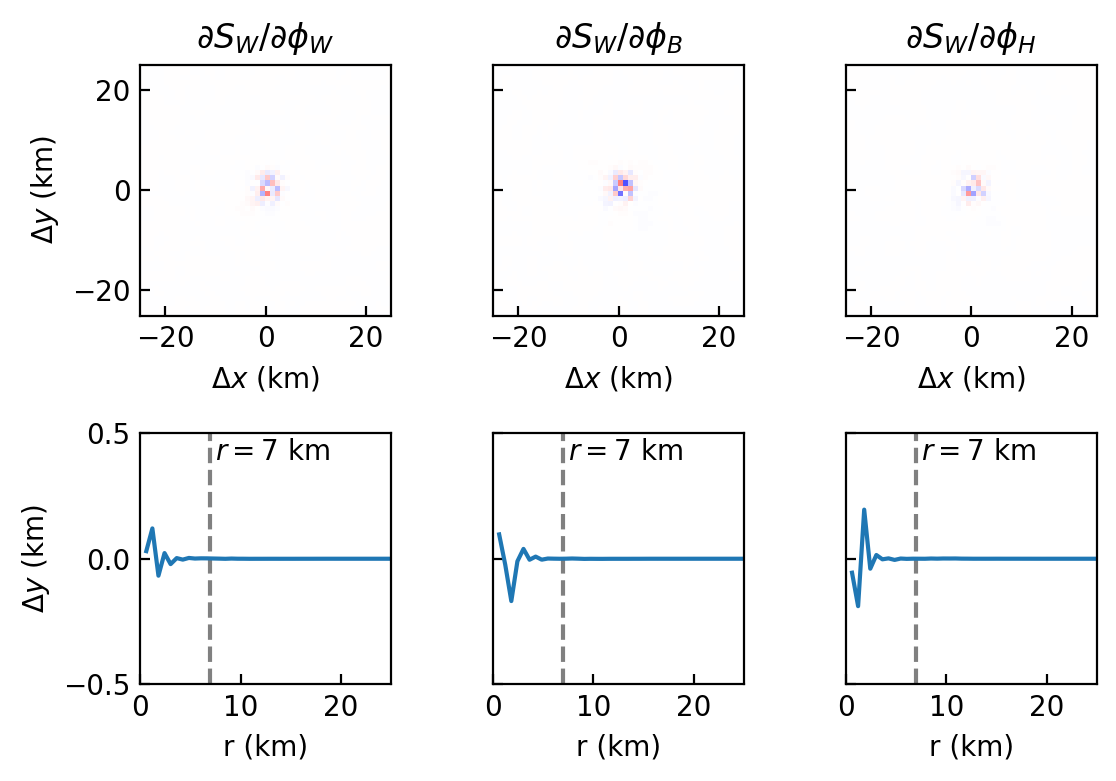

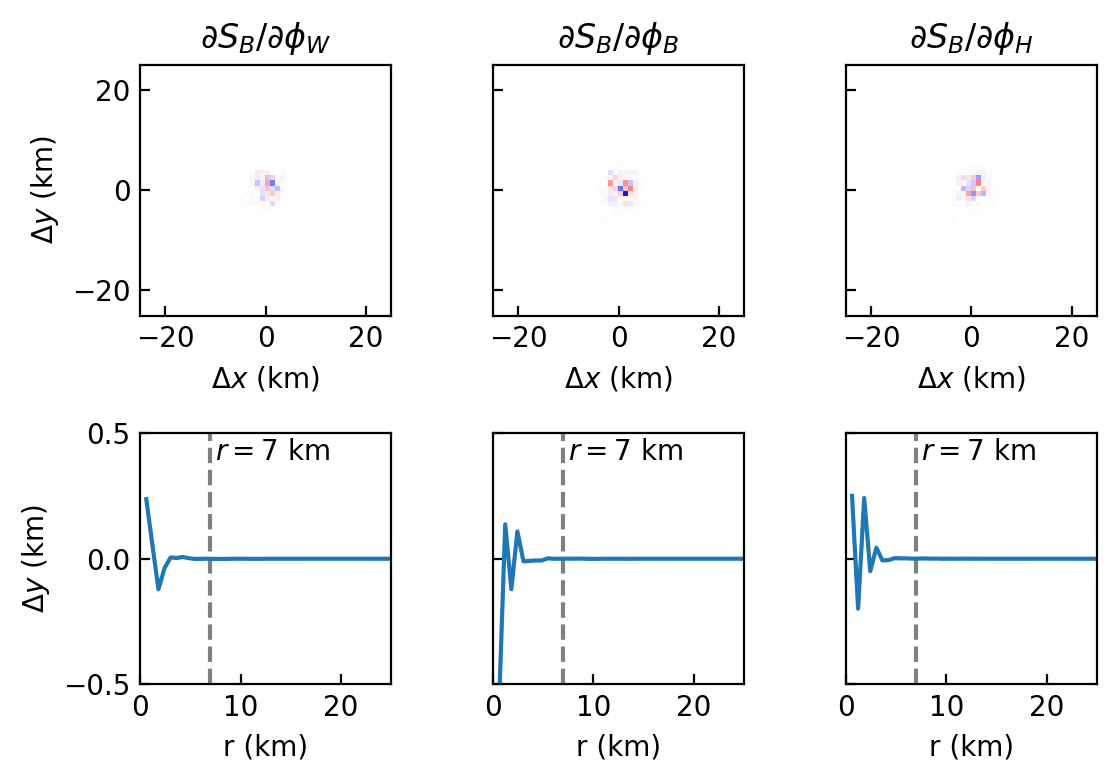

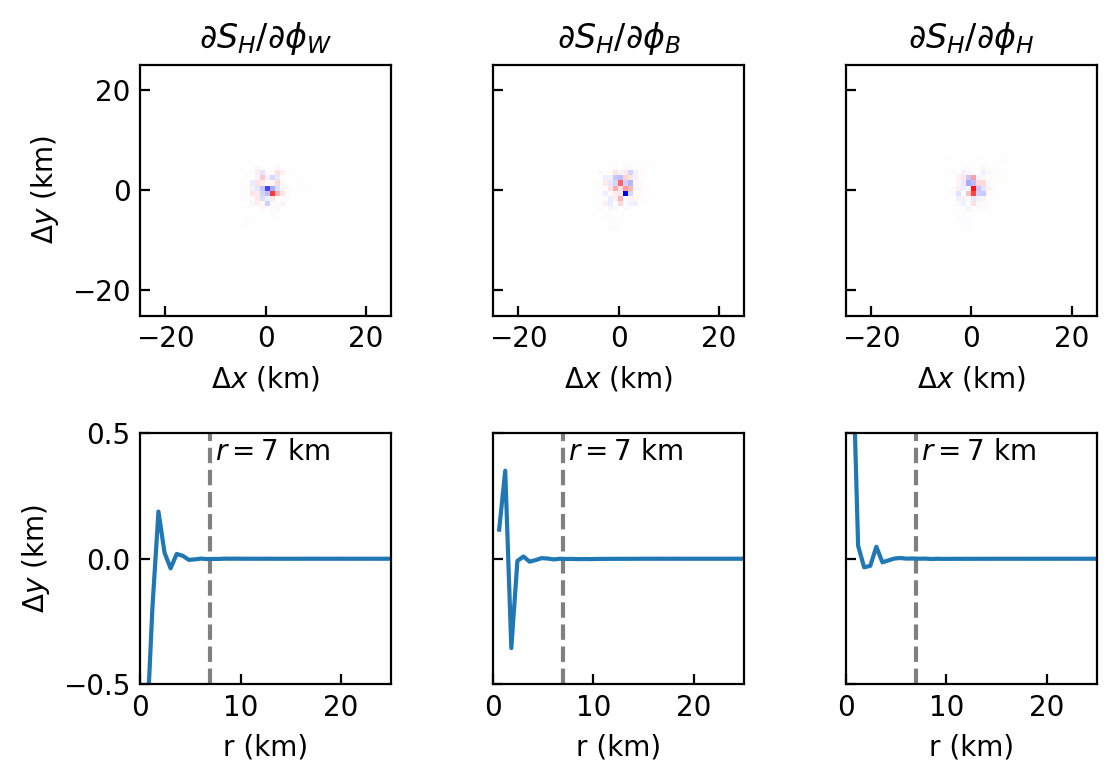

In [16]:
from scipy.interpolate import RectBivariateSpline

xmax = np.max(np.max([np.max(Xi) for Xi in X_s]))
ymax = np.max([np.max(Yi) for Yi in Y_s])

print(xmax, ymax)

x = np.linspace(-xmax, xmax, int(2*xmax))
y = np.linspace(-ymax, ymax, int(2*ymax))
x, y = np.meshgrid(x, y, indexing='xy')

rgrid = np.linalg.norm(np.stack([x, y]), axis=0)
r = np.linspace(0, 60, 100)

labels = ['W', 'B', 'H']

for ii in range(3):
    fig, ax = plt.subplots(2, 3, figsize=(6, 4), dpi=200,
                           sharey='row', sharex='row')
    for jj in range(3):
        Gr = np.zeros(rgrid.shape)
        for kk in range(len(G_s)):
            Gsj = G_s[kk][ii, jj]
            xj = X_s[kk]
            yj = Y_s[kk]
            Gr += RectBivariateSpline(yj[:,0], xj[0,:], Gsj)(y[:, 0], x[0, :])

        Gr = Gr / (4*40)
        #Gr = Gr / np.abs(Gr).max()
        ax[0, jj].pcolormesh(x, y, Gr,
                            vmin=-1, vmax=1, cmap='bwr')

        ax[0, jj].set(
            xlabel=r'$\Delta x$ (km)',
            aspect='equal',
        )

        gr = np.zeros(len(r)-1)
        for j in range(len(r)-1):
            gr[j] = np.mean(Gr[(rgrid>=r[j])*(rgrid<r[j+1])])
        ax[1, jj].plot(r[1:], gr)
        ax[1, jj].set(xlabel='r (km)')
        
        ax[0,jj].set(
            xlim=[-25, 25],
            ylim=[-25, 25])
        ax[1,jj].set(
            xlim=[0, 25],
            ylim=[-0.5, 0.5],
            xticks=[0, 10, 20],
            yticks=[-0.5, 0, 0.5])
        ax[1,jj].set_aspect(np.ptp(ax[1,jj].get_xlim()) / np.ptp(ax[1,jj].get_ylim()))

        r0 = 7
        ax[1,jj].axvline(r0, linestyle='--', zorder=-1, color='grey')
        ax[1,jj].text(r0+0.5, 0.48, f'$r={r0}$ km', va='top', ha='left',
                     transform=ax[1,jj].transData)

        ax[0,jj].tick_params(which='both', direction='in')
        ax[1,jj].tick_params(which='both', direction='in')
    
        ax[0,jj].set_title(f'$\\partial S_{labels[ii]} / \\partial \\phi_{labels[jj]}$')
    ax[0,0].set_ylabel(r'$\Delta y$ (km)')
    ax[1,0].set_ylabel(r'$\Delta y$ (km)')

    plt.tight_layout()